In [1]:
import torch
import torch.nn as nn 
from torch.functional import F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import xarray as xr
import datashader as ds
import datashader.transfer_functions as tf

from tqdm.notebook import tqdm

/Users/nicholasmartin/Programming/Research/optimal-execution-kernel-decomposition/venv/lib/python3.10/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
def non_markovian_midprice(inital_prices, 
                        permenant_price_impact_func, 
                        nu_vals,
                        kernel_function, 
                        dt, 
                        rng,
                        num_paths,
                        num_timesteps,
                        sigma):

    final_time = num_timesteps*dt

    permenant_price_impact_vals = permenant_price_impact_func(nu_vals)
    kernel_vals = np.array([kernel_function(final_time, timestep*dt) for timestep in range(num_timesteps)])
    kernel_integrand = kernel_vals.reshape(-1,1) * permenant_price_impact_vals * dt
    kernel_integrand = np.vstack([inital_prices, kernel_integrand])
    kernel_integral = np.cumsum(kernel_integrand, axis=0)

    noise_process = rng.normal(0,1, size=(num_timesteps, num_paths)) 
    brownian_motion_integrand = sigma*(dt**0.5)*noise_process
    zeros = np.zeros((1, num_paths))
    brownian_motion_integrand = np.vstack([zeros, brownian_motion_integrand])

    brownian_motion_integral = np.cumsum(brownian_motion_integrand, axis=0)
    prices = kernel_integral+brownian_motion_integral

    return prices, noise_process

In [3]:
rng = np.random.default_rng(123)

num_paths = 10000
num_timesteps = 1000
final_time = 1
dt = final_time/num_timesteps
initial_price = 1
inital_prices = np.ones((1, num_paths)) * initial_price

permenant_price_impact_func = lambda x: 0.01*x
kernel_function = lambda x,y: (np.abs((x-y)+1e-6)**(0.51-1))

nu_vals = rng.uniform(-50, 100,size=(num_timesteps, num_paths))

sigma = 0.1

In [4]:
sim_prices, noise_process = non_markovian_midprice(inital_prices=inital_prices,
                             permenant_price_impact_func=permenant_price_impact_func,
                             nu_vals=nu_vals,
                             kernel_function=kernel_function,
                             dt=dt,
                             rng=rng,
                             num_paths=num_paths,
                             num_timesteps=num_timesteps,
                             sigma=sigma)

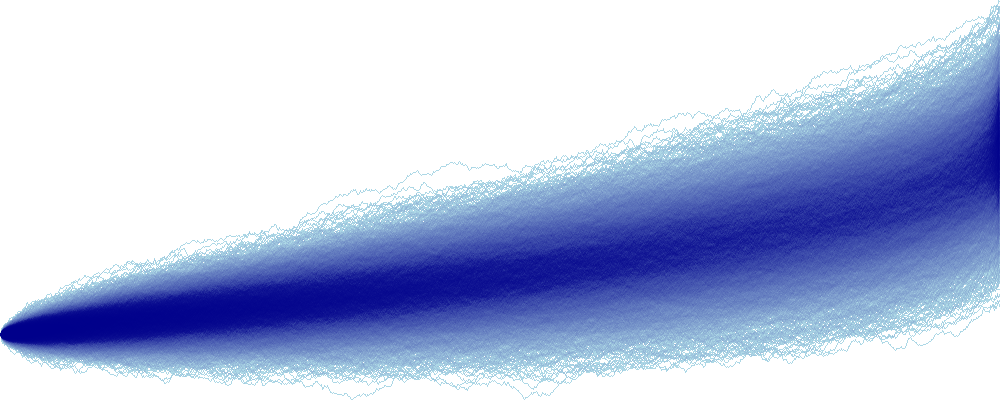

In [5]:
n = num_paths
points = num_timesteps
time = np.linspace(0, 1, num_timesteps)

walks = pd.DataFrame(sim_prices.T)

cvs = ds.Canvas(plot_height=400, plot_width=1000)
agg = cvs.line(walks, x=time, y=list(range(points)), agg=ds.count(), axis=1, line_width=0)
img = tf.shade(agg, how='eq_hist')

img

# NN Approach

In [28]:
class MLP(nn.Module):

    def __init__(self, decomp_dim: int):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, decomp_dim*2)

        self._log_sigma = nn.Parameter(data=torch.FloatTensor([0]))

    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
    
    @property
    def sigma(self):
        return torch.exp(self._log_sigma)
    
class MultiTaskLoss(nn.Module):

    def __init__(self):
        super(MultiTaskLoss, self).__init__()

        self._log_mean_sigma = nn.Parameter(data=torch.FloatTensor([1]))
        self._log_std_sigma = nn.Parameter(data=torch.FloatTensor([1]))

        return None
    
    def forward(self, loss):

        return (np.exp(self._log_mean_sigma)*loss[0]) + (np.exp(self._log_std_sigma)*loss[1]) + 0.01+(1/np.exp(self._log_mean_sigma) + 1/np.exp(self._log_std_sigma))

In [29]:
decomp_dim = 10
num_episodes = 10
batch_size = 256

network = MLP(decomp_dim=decomp_dim)
mtloss = MultiTaskLoss()
optimizer = torch.optim.Adam(params=[*network.parameters(), *mtloss.parameters()], lr=1e-3)

In [8]:
loss_vals = {}
for episode in tqdm(range(num_episodes)): 
    loss_vals[episode] = []

    for batch_index in range(1, int(num_paths/batch_size)+1):

        lower_bound = int((batch_index-1)*batch_size)
        upper_bound = int((batch_index)*batch_size)

        B_n_t = torch.zeros((decomp_dim, batch_size))
        S_t = torch.ones((1, batch_size)) * initial_price

        true_vals = sim_prices[:, lower_bound:upper_bound]
        batch_nu_vals = nu_vals[:, lower_bound:upper_bound]

        for timestep in range(num_timesteps):

            price_impacts = torch.FloatTensor(permenant_price_impact_func(batch_nu_vals[timestep]))
            net_vals = network(torch.FloatTensor([timestep*dt]))

            f_vals = net_vals[:decomp_dim]
            f_prime_vals = net_vals[decomp_dim:]

            kernel_time_t = f_vals.dot(f_vals)
            kernel_price_impact = kernel_time_t * price_impacts * dt

            w_t = (dt**0.5)*torch.randn((batch_size))
            sigma_w_t = network.sigma * w_t

            dB_n_t = torch.tile(f_vals, dims=(batch_size, 1)).T * price_impacts * dt
            B_n_t = B_n_t.detach() + dB_n_t
            sum_of_sub_procces = torch.matmul(f_prime_vals, B_n_t) * dt

            dS_t = kernel_price_impact + sigma_w_t + sum_of_sub_procces
            S_t = S_t.detach() + dS_t

            pred_mean_times = torch.mean(S_t)
            true_means = torch.FloatTensor([np.mean(true_vals)])

            pred_std = torch.std(S_t)
            true_stds = torch.FloatTensor([np.std(true_vals)])

            diff_means = torch.abs(pred_mean_times-true_means)
            diff_stds = torch.abs(pred_std-true_stds)

            loss = mtloss(torch.FloatTensor([diff_means,diff_stds]))

            loss_vals[episode].append({'timestep': timestep,
                                       'loss': loss.item()})

            network.zero_grad()
            optimizer.zero_grad()

            loss.backward()
            optimizer.step()

            network.zero_grad()
            optimizer.zero_grad()

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

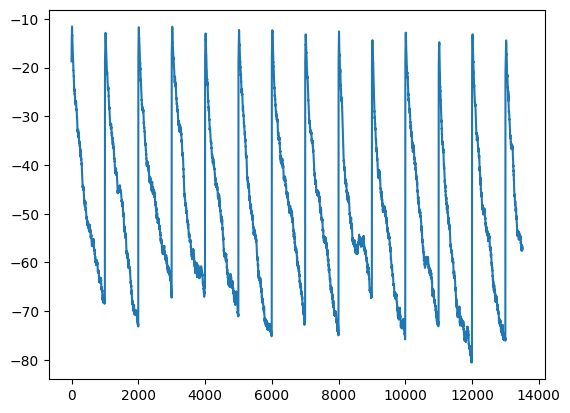

In [12]:
plt.plot(pd.DataFrame(loss_vals[2])['loss'][:])
plt.show()

In [13]:
network.eval()

batch_size = 1_000

batch_nu_vals = rng.uniform(-50, 100,size=(num_timesteps, batch_size))

B_n_t = torch.zeros((decomp_dim, batch_size))
S_t = torch.ones((1, batch_size)) * initial_price

B_n_list = [B_n_t.detach().numpy()]
S_t_list = [S_t.detach().numpy()]

for timestep in range(num_timesteps):

    price_impacts = torch.FloatTensor(permenant_price_impact_func(batch_nu_vals[timestep]))
    net_vals = network(torch.FloatTensor([timestep*dt]))

    f_vals = net_vals[:decomp_dim]
    f_prime_vals = net_vals[decomp_dim:]

    kernel_time_t = f_vals.dot(f_vals)
    kernel_price_impact = kernel_time_t * price_impacts * dt

    w_t = (dt**0.5)*torch.randn((batch_size))
    sigma_w_t = network.sigma * w_t

    dB_n_t = torch.tile(f_vals, dims=(batch_size, 1)).T * price_impacts * dt
    B_n_t = B_n_t.detach() + dB_n_t
    B_n_list.append(B_n_t.detach().numpy())

    sum_of_sub_procces = torch.matmul(f_prime_vals, B_n_t) * dt

    dS_t = kernel_price_impact + sigma_w_t + sum_of_sub_procces
    S_t = S_t.detach() + dS_t

    S_t_list.append(S_t.detach().numpy())

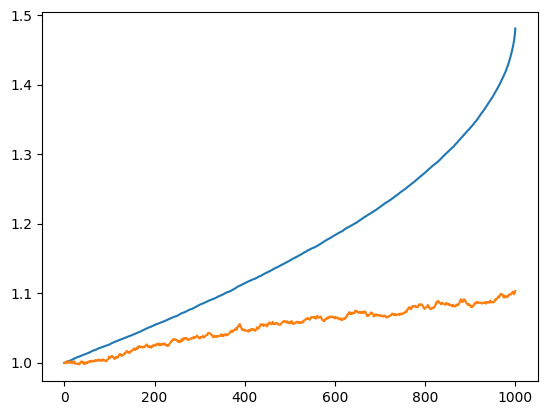

In [14]:
plt.plot(sim_prices[:, :1000].mean(axis=1))

nn_sim_prices = np.vstack(S_t_list)

plt.plot(nn_sim_prices.mean(axis=1))

plt.show()

In [15]:
network.sigma

tensor([1.], grad_fn=<ExpBackward0>)

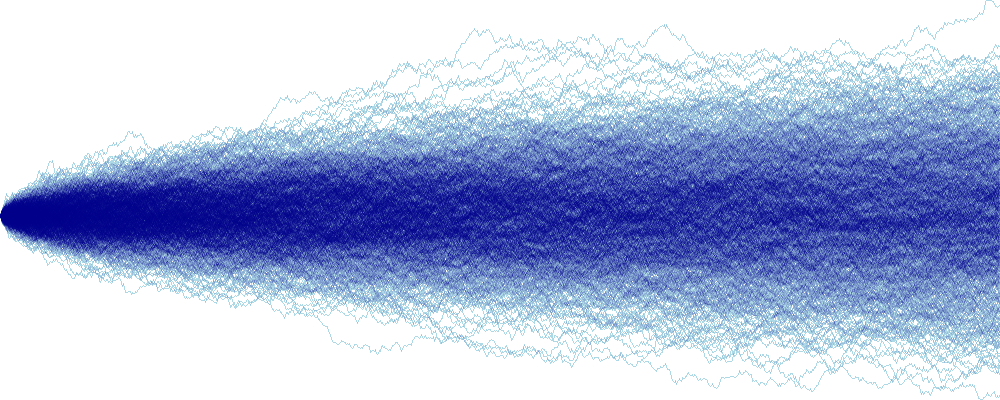

In [16]:
nn_sim_prices = np.vstack(S_t_list)

n = num_paths
points = num_timesteps
time = np.linspace(0, 1, num_timesteps)

walks = pd.DataFrame(nn_sim_prices.T)

cvs = ds.Canvas(plot_height=400, plot_width=1000)
agg = cvs.line(walks, x=time, y=list(range(points)), agg=ds.count(), axis=1, line_width=0)
img = tf.shade(agg, how='eq_hist')

img

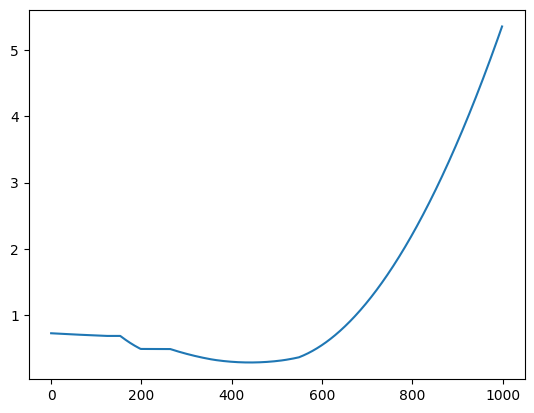

In [ ]:
kernel_plot = []

for i in range(0, num_timesteps):
    val = network(torch.FloatTensor([i*dt]))[:decomp_dim]
    kernel_plot.append(val.dot(val).detach().item())

plt.plot(kernel_plot)
plt.show()